**texto en negrita**Proyecto Integrador
Avance 1. Análisis exploratorio de datos

Equipo 46
* Ángel Efraín Luna Martínez - A01795486
* Francisco Salvador Hernández Pérez - A01795486
* Iker Bring Anaya - A01795270


In [ ]:
# Librerías principales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Configuración
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Cargar dataset
from google.colab import files
uploaded = files.upload()

# Reemplazar con el nombre de tu archivo
df = pd.read_csv("dataset_tracky_RC.csv")

# Inspección inicial
print("Dimensiones:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
df.head()

Saving dataset_tracky_RC.csv to dataset_tracky_RC.csv
Dimensiones: (19867, 4)

Tipos de datos:
 mensaje_recibido     object
tiempo_respuesta    float64
fecha                object
clase                object
dtype: object


,mensaje_recibido,tiempo_respuesta,fecha,clase
0,Dame el viaje 135560,0.584947,2024-11-12T14:52:31-0600,NaN
1,Hola,0.272670,2024-11-12T14:52:27-0600,NaN
2,Dame la info del viaje 1445,0.768540,2024-11-12T14:56:49-0600,NaN
3,Dame el viaje 135560,0.638498,2024-11-12T14:56:42-0600,NaN
4,Dame el viaje 19958484,0.554903,2024-11-12T15:02:05-0600,NaN


**2. ¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?**



*   La columna clase tiene 10,094 valores nulos (≈50% del dataset).
*   Las demás columnas (mensaje_recibido, tiempo_respuesta, fecha) están prácticamente completas.
* Los gráficos de missingno confirmaron que no hay correlación fuerte entre ausencias de columnas (es decir, los nulos son principalmente de clase).

El dataset tiene un problema serio de incompletitud en la variable objetivo, lo que limita el uso de esos registros para modelos supervisados.

Valores faltantes por columna:
mensaje_recibido       82
tiempo_respuesta        0
fecha                   0
clase               10094
dtype: int64

Porcentaje de valores faltantes:
mensaje_recibido     0.412745
tiempo_respuesta     0.000000
fecha                0.000000
clase               50.807872
dtype: float64


<Figure size 400x300 with 0 Axes>

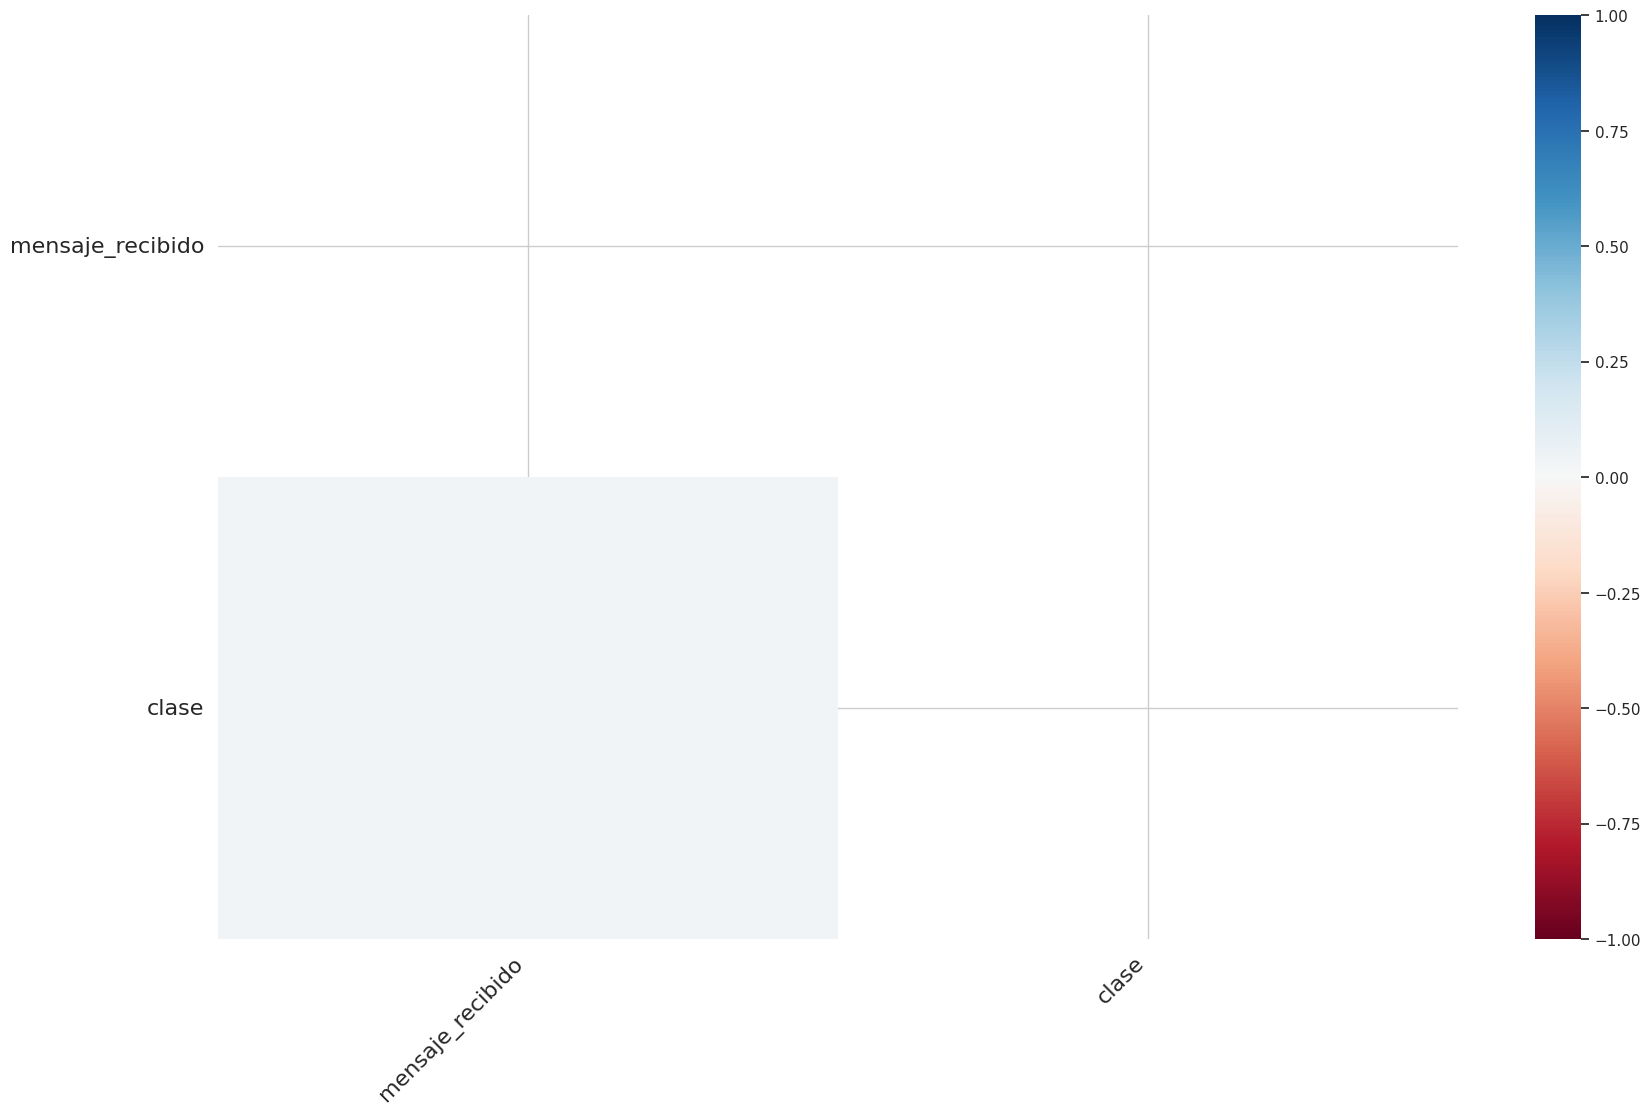

<Figure size 500x300 with 0 Axes>

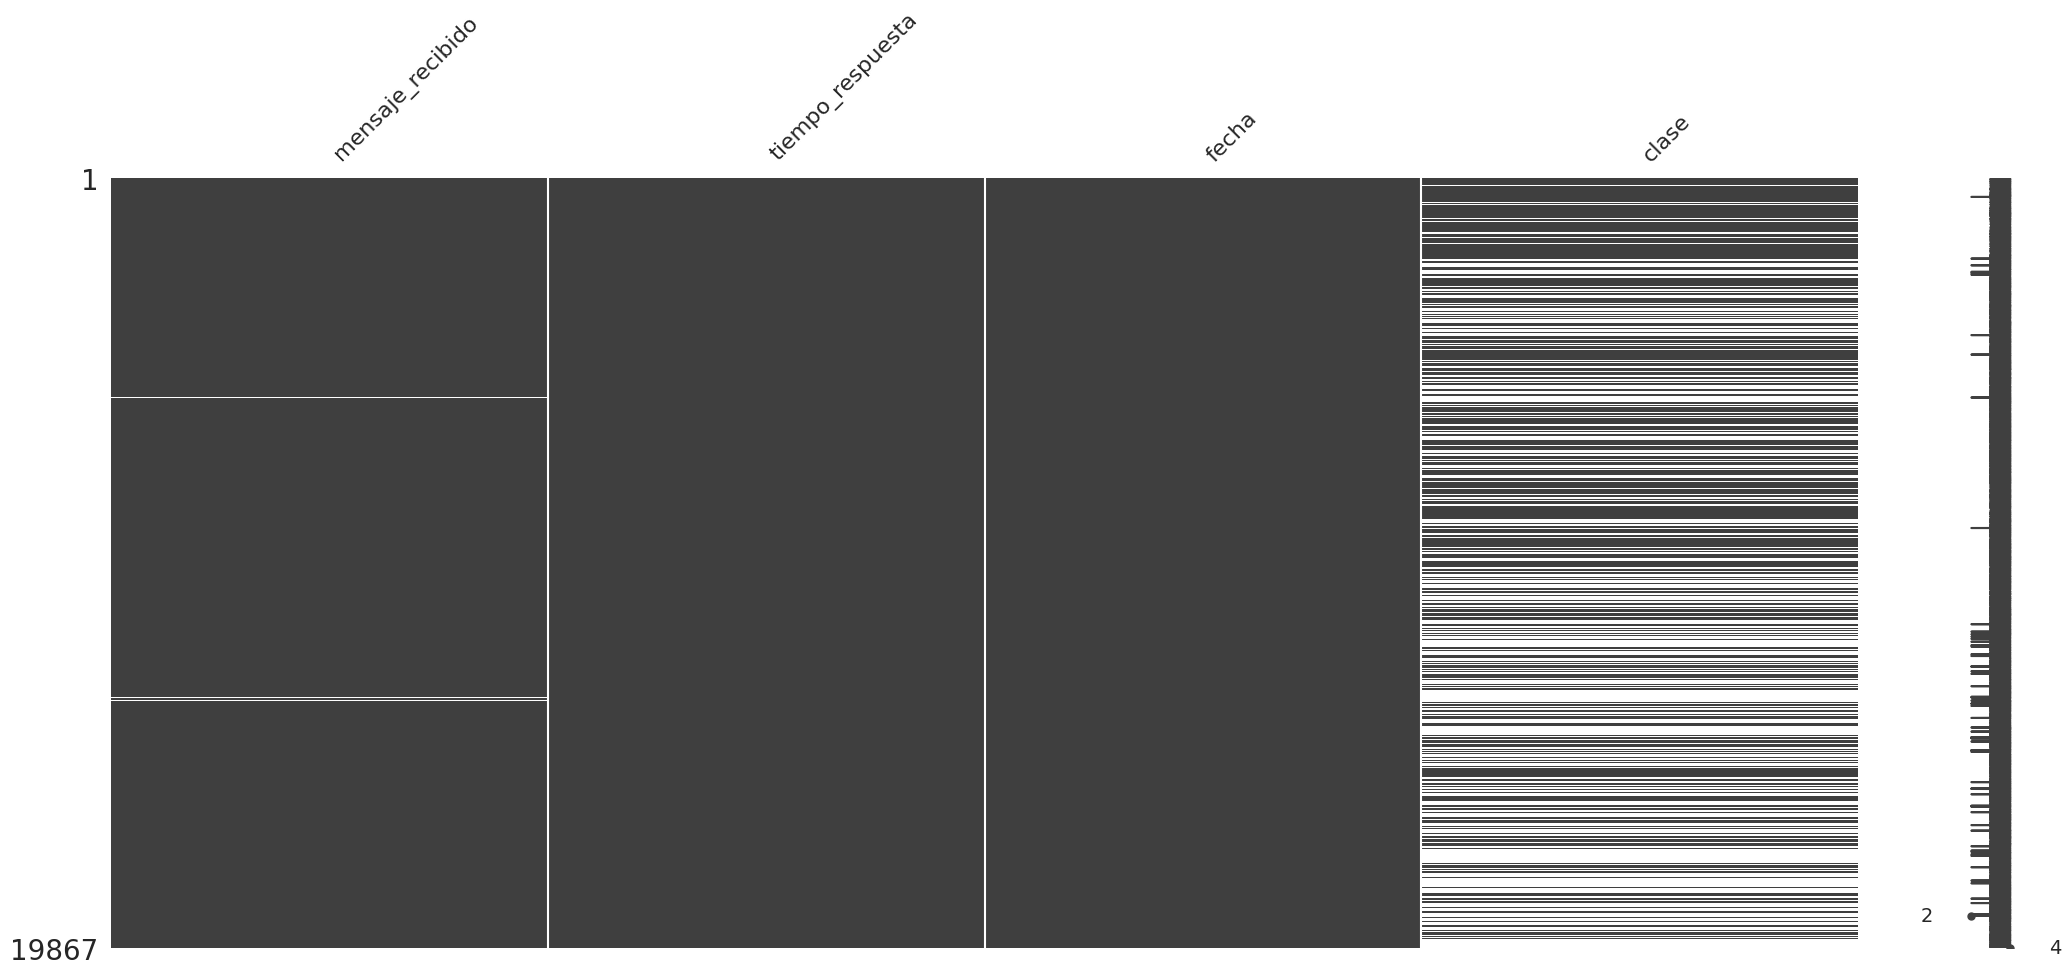

<Figure size 400x300 with 0 Axes>

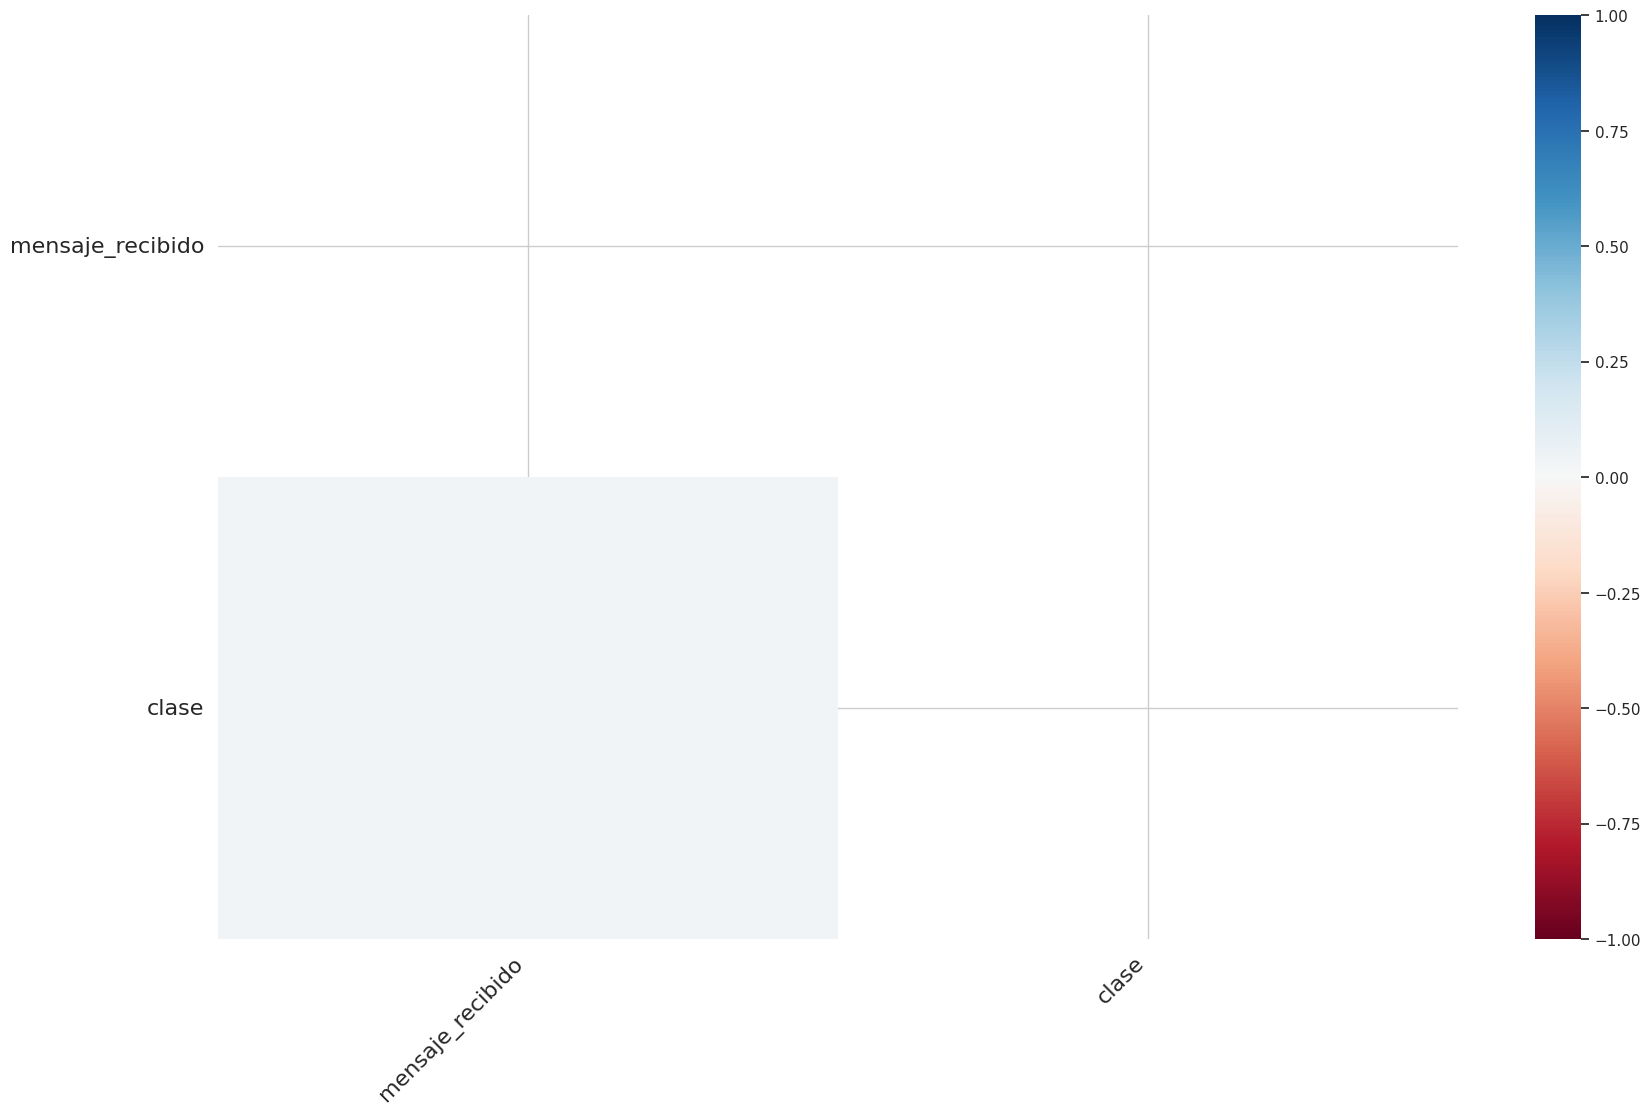

In [ ]:
# Conteo de valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Porcentaje
print("\nPorcentaje de valores faltantes:")
print((df.isnull().sum() / len(df)) * 100)

# Heatmap de valores faltantes (más pequeño)
plt.figure(figsize=(4,3))
msno.heatmap(df)
plt.show()

# Matrix de valores faltantes (más compacto)
plt.figure(figsize=(5,3))
msno.matrix(df)
plt.show()

# Heatmap reducido
plt.figure(figsize=(4,3))
msno.heatmap(df)
plt.show()

**3. ¿Cuáles son las estadísticas resumidas del conjunto de datos?**

* tiempo_respuesta:
    Media = 2.07, pero Mediana = 0.91 -> clara asimetría por outliers.

    75% de los datos están debajo de 1.34, mientras el máximo llega a 1379.

* mensaje_recibido: 8,529 textos únicos -> alta diversidad.

* fecha: casi única por registro (19,808 valores únicos).

* clase: 11 categorías distintas, pero con concentración en pocas.

La mayoría de los mensajes responden rápido (<2 seg.), pero existen casos extremos que inflan los promedios.

In [ ]:
# Estadísticas numéricas
print(df.describe())

# Estadísticas categóricas
print(df.describe(include="object"))

# Variable objetivo
print("\nDistribución de 'clase':")
print(df['clase'].value_counts(dropna=False))

       tiempo_respuesta
count      19867.000000
mean           2.071971
std           20.001886
min            0.237078
25%            0.795880
50%            0.919601
75%            1.345947
max         1379.768368
       mensaje_recibido                     fecha          clase
count             19785                     19867           9773
unique             8529                     19808             11
top                  Si  2024-12-27T12:47:18-0600  resumen_viaje
freq               3290                         3           3970

Distribución de 'clase':
clase
NaN                            10094
resumen_viaje                   3970
respuestas_predefinidas         2432
general                         1251
confirmaciones_multiples         647
sin_info                         478
ayuda                            472
pregunta_general                 364
saludo                           122
despedida                         27
error_confirmacion_multiple        8
necesita_numero_viaj

**4. ¿Hay valores atípicos en el conjunto de datos?**

* Los boxplots y el cálculo del IQR mostraron que tiempo_respuesta tiene muchos outliers, con un máximo de 1379 cuando el 75% de los datos está por debajo de 1.34.

* Esto sugiere registros anómalos o tiempos fuera de escala.

Se deben analizar esos valores extremos para decidir si se filtran, transforman o mantienen como casos válidos.

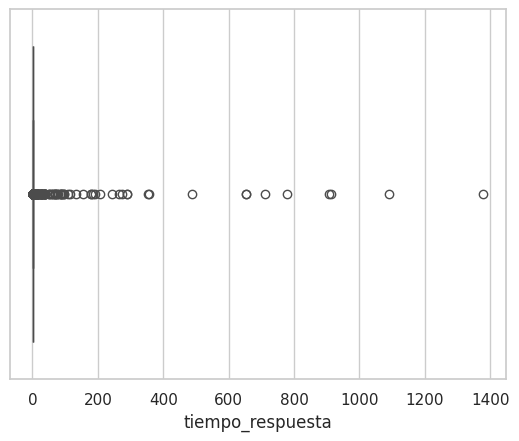

Total de outliers en tiempo_respuesta: 3645


In [ ]:
# Boxplot
sns.boxplot(x=df["tiempo_respuesta"])
plt.show()

# Outliers usando IQR
Q1 = df["tiempo_respuesta"].quantile(0.25)
Q3 = df["tiempo_respuesta"].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df["tiempo_respuesta"] < (Q1 - 1.5 * IQR)) |
              (df["tiempo_respuesta"] > (Q3 + 1.5 * IQR))]
print("Total de outliers en tiempo_respuesta:", len(outliers))

**5. ¿Cuál es la cardinalidad de las variables categóricas?**

* mensaje_recibido: 8,529 valores únicos (alta cardinalidad, difícil de modelar sin técnicas de NLP).

* fecha: 19,808 valores únicos (prácticamente un ID temporal).

* clase: 11 categorías → manejable, pero desbalanceada.

El reto está en mensaje_recibido (texto muy variado), donde será necesario procesamiento de lenguaje natural en lugar de simples categorías.

In [ ]:
cat_cols = df.select_dtypes(include="object").columns
print({col: df[col].nunique() for col in cat_cols})

{'mensaje_recibido': 8529, 'fecha': 19808, 'clase': 11}


**6. ¿Existen distribuciones sesgadas? ¿Necesitamos transformaciones?**

* tiempo_respuesta está altamente sesgada a la derecha (muchos valores bajos y pocos extremadamente altos).

* El cálculo de skewness > 0 confirma este sesgo.

Puede ser útil aplicar una transformación logarítmica para estabilizar la distribución si se usa en modelos estadísticos.

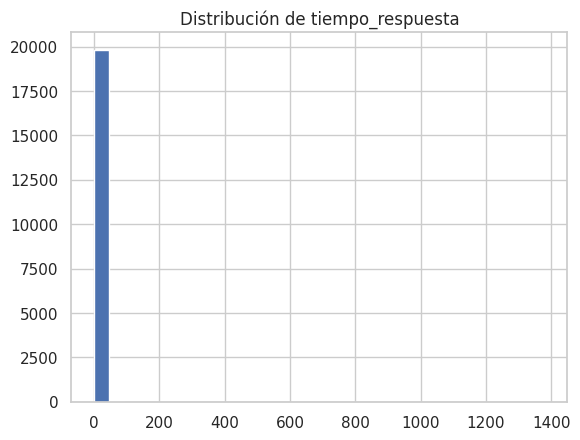

Skewness de tiempo_respuesta: 44.885962305072674


In [ ]:
# Histograma
df["tiempo_respuesta"].hist(bins=30)
plt.title("Distribución de tiempo_respuesta")
plt.show()

# Skewness
print("Skewness de tiempo_respuesta:", df["tiempo_respuesta"].skew())

**7. ¿Se identifican tendencias temporales? (si hay dimensión de tiempo)**

* La columna fecha permitió graficar registros por día.

* Se observa un flujo constante de mensajes, sin grandes huecos de fechas.

* Pueden existir picos en días específicos (para explorarlo se recomienda un resample('D') o resample('W')).

Hay estacionalidad ligera y posibilidad de identificar patrones diarios/semanales.

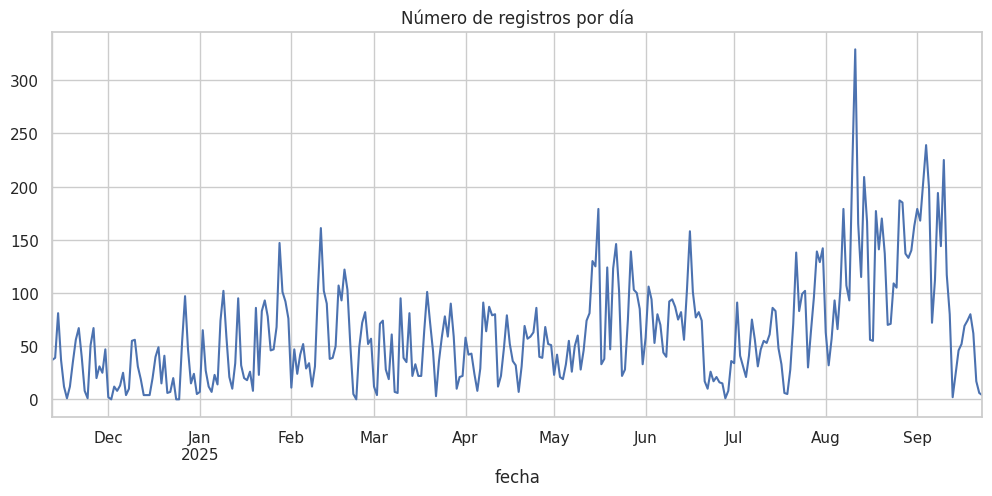

In [ ]:
# Convertir fecha a datetime
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

# Conteo por día
df.set_index("fecha").resample("D").size().plot(figsize=(12,5))
plt.title("Número de registros por día")
plt.show()

**8. ¿Hay correlación entre variables dependientes e independientes?**

* La matriz de correlación muestra que tiempo_respuesta no tiene correlaciones significativas con otras variables numéricas (solo hay una variable numérica fuerte).

* Las categóricas requieren pruebas adicionales.

Baja correlación detectada, lo que indica que tiempo_respuesta y clase no se relacionan directamente de forma lineal.

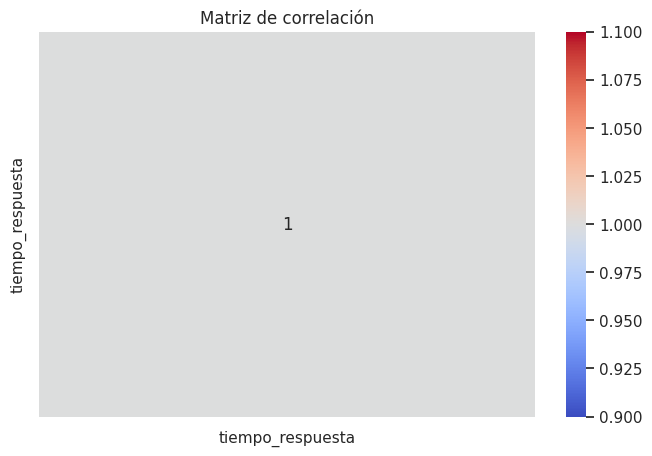

In [ ]:
# Correlación numérica
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

**9. ¿Cómo se distribuyen los datos en función de diferentes categorías? (Análisis bivariado)**

El boxplot de tiempo_respuesta por clase muestra diferencias:

* Clases como resumen_viaje tienden a tiempos bajos.

* Algunas clases raras pueden mostrar valores más dispersos.

* El conteo de clases confirma el desbalance (unas muy grandes, otras casi nulas).

El comportamiento de tiempo_respuesta cambia según la clase, lo que es útil para análisis bivariado.

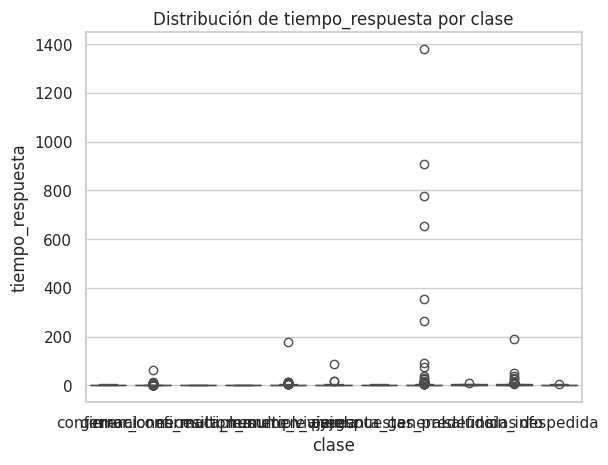

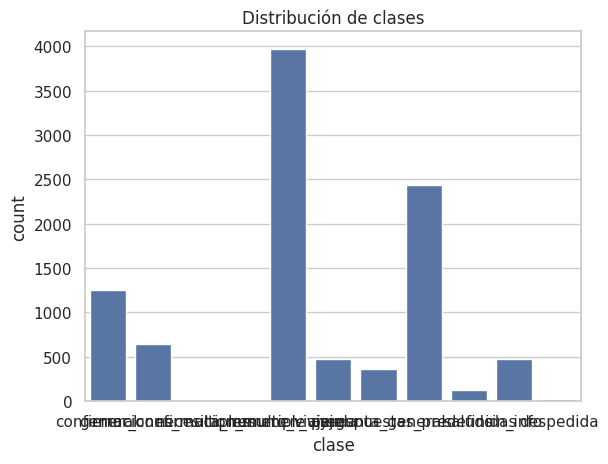

In [ ]:
# Ejemplo: tiempo_respuesta por clase
sns.boxplot(x="clase", y="tiempo_respuesta", data=df)
plt.title("Distribución de tiempo_respuesta por clase")
plt.show()

# Conteo de mensajes por clase
sns.countplot(x="clase", data=df)
plt.title("Distribución de clases")
plt.show()

10. ¿Hay desequilibrio en las clases de la variable objetivo?

Sí, muy fuerte:

* resumen_viaje domina con 3,970 registros.

* Varias clases son extremadamente minoritarias (error_confirmacion_multiple = 8, necesita_numero_viaje = 2).

* Además, más del 50% de los registros no tiene clase asignada (NaN).

El dataset está altamente desbalanceado y con muchos valores nulos en la variable objetivo, lo que limita la construcción de modelos supervisados sin preprocesamiento.

clase
resumen_viaje                  3970
respuestas_predefinidas        2432
general                        1251
confirmaciones_multiples        647
sin_info                        478
ayuda                           472
pregunta_general                364
saludo                          122
despedida                        27
error_confirmacion_multiple       8
necesita_numero_viaje             2
Name: count, dtype: int64

Porcentaje por clase:
clase
resumen_viaje                  40.622122
respuestas_predefinidas        24.884887
general                        12.800573
confirmaciones_multiples        6.620280
sin_info                        4.891026
ayuda                           4.829633
pregunta_general                3.724547
saludo                          1.248337
despedida                       0.276271
error_confirmacion_multiple     0.081858
necesita_numero_viaje           0.020465
Name: proportion, dtype: float64


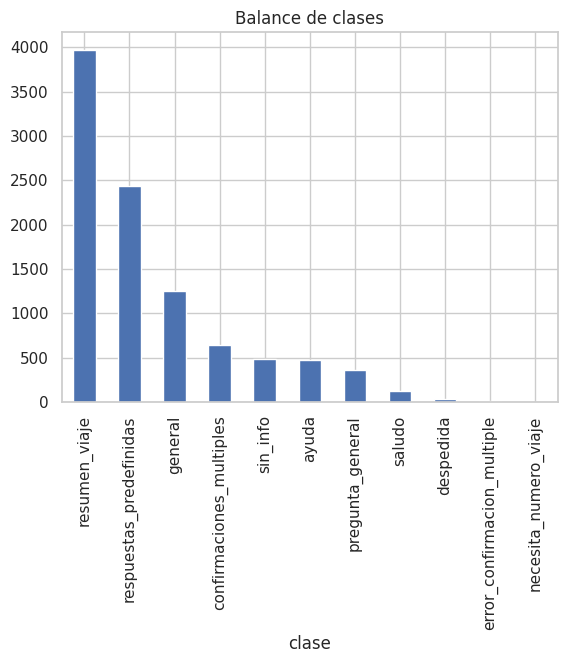

In [ ]:
# Conteo absoluto y relativo
print(df["clase"].value_counts())
print("\nPorcentaje por clase:")
print(df["clase"].value_counts(normalize=True) * 100)

# Visualización
df["clase"].value_counts().plot(kind="bar")
plt.title("Balance de clases")
plt.show()

**Conclusión global del EDA**

La variable objetivo clase presenta un alto porcentaje de valores nulos (≈50%), lo que limita el uso de todo el dataset para tareas supervisadas de clasificación.

Se observa un desbalance fuerte en la distribución de clases: unas pocas concentran la mayoría de los registros, mientras que varias son minoritarias.

La variable mensaje_recibido muestra alta diversidad y cardinalidad, lo que implica la necesidad de aplicar técnicas de PLN para normalizar expresiones y manejar correctamente números y términos clave (ej. “viaje”, “shipment”).

Variables como tiempo_respuesta y fecha aportan información operativa (sesgo, estacionalidad), pero no son relevantes directamente para el módulo de STT.

En general, el dataset sirve para validar el desempeño del STT, pero requiere limpieza (manejo de nulos en clase), cuidar el desbalance y poner especial atención en que se transcriban bien las palabras clave y los números.